<a href="https://colab.research.google.com/github/iamhannahkoh/DeepLearning/blob/main/Computer_Vision_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computer Vision with Transfer Learning


**About the Data**

This exercise uses a subset of the Dogs vs. Cats dataset provided by Kaggle. The original training archive contains 25,000 images of dogs and cats. In this exercise, we will only use a part of the Kaggle dataset, train an algorithm on these training images, and predict the labels for images that the model hasn't seen previously (1 = dog and 0 = cat). You can find more information on the full dataset on the Kaggle website (https://www.kaggle.com/c/dogs-vs-cats/overview).

**About the Pre-difined Model**

In this exercise, we will use a pre-trained model called InceptionV3 to build the model. TensorFlow provides Keras Applications, which are deep larning models that are made available alsongisde pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning. You can find the full list of Keras pre-trained models on this website: https://keras.io/api/applications/. 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

### 1. Import the pre-defined model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

--2021-01-07 09:22:54--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  77.1MB/s    in 1.1s    

2021-01-07 09:22:55 (77.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# Set the last layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


### 2. Set up the data

In [ ]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-01-07 09:23:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  68.8MB/s    in 1.0s    

2021-01-07 09:23:14 (68.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Define directories

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir =os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
# Image Generator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range =0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 3. Build the model

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation ='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)  

# Final sigmoid layer
x = layers.Dense  (1, activation='sigmoid')(x)  

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs=20,
                    validation_steps = 50,
                    verbose =2)

Epoch 1/20
100/100 - 117s - loss: 1.1337 - accuracy: 0.8310 - val_loss: 0.0975 - val_accuracy: 0.9540
Epoch 2/20
100/100 - 118s - loss: 0.3262 - accuracy: 0.8865 - val_loss: 0.1541 - val_accuracy: 0.9480
Epoch 3/20
100/100 - 114s - loss: 0.3074 - accuracy: 0.8950 - val_loss: 0.1308 - val_accuracy: 0.9540
Epoch 4/20
100/100 - 112s - loss: 0.2952 - accuracy: 0.9090 - val_loss: 0.2841 - val_accuracy: 0.9240
Epoch 5/20
100/100 - 112s - loss: 0.2776 - accuracy: 0.9170 - val_loss: 0.3124 - val_accuracy: 0.9190
Epoch 6/20
100/100 - 113s - loss: 0.2337 - accuracy: 0.9290 - val_loss: 0.1191 - val_accuracy: 0.9680
Epoch 7/20
100/100 - 112s - loss: 0.2528 - accuracy: 0.9220 - val_loss: 0.1217 - val_accuracy: 0.9580
Epoch 8/20
100/100 - 112s - loss: 0.2395 - accuracy: 0.9265 - val_loss: 0.2503 - val_accuracy: 0.9400
Epoch 9/20
100/100 - 113s - loss: 0.1986 - accuracy: 0.9370 - val_loss: 0.2002 - val_accuracy: 0.9500
Epoch 10/20
100/100 - 112s - loss: 0.2243 - accuracy: 0.9375 - val_loss: 0.1314 - 

### 4. Visualization

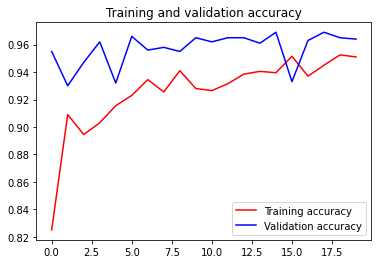

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label ='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Data source: DeepLearning.AI TensorFlow Developer Professional Certificate Specialization on Coursera